# Genetic algorithm implementation 

## TODO
* ¿Cómo hacer el mutación para $\mathbf{k}$?
* ¿Qué fitness tiene máás sentido?

Given data $\mathbf{x} \in \mathbb{R}^{M}$, a random basis $\mathbf{B} \in \mathbb{R}^{D \times M}$ with $B_{i j} \sim \mathcal{N}(0, \sigma)$, $\mathbf{b} \in \mathbb{R}^D$ and $b_{i} \sim \mathcal{U}(0,2 \pi)$ and a nonlinear trasformation $\varphi: \mathbb{R}^{D} \rightarrow \mathbb{R}^{D}$ defined as
$$\varphi(\mathbf{z}) = \cos (\mathbf{z}+\mathbf{b}) \sin (\mathbf{z}) $$, where $\mathbf{z} =\mathbf{B} \mathbf{x}  $ we want to devise a method to recover $\mathbf{x}$ from  $\mathbf{h} = \cos(\mathbf{x} \mathbf{B} + \mathbf{b}$)


## Utilities

This section defines various utilities that will be used in the code, such as loading utilities and constants.

In [1]:
import numpy as np
import torch
import sklearn.datasets
import sklearn.linear_model
import sklearn.model_selection
from torch import nn
from tqdm.notebook import tqdm

import random

#Constants
POPULATION_SIZE = 100
MAX_ITER = 100000
DIMENSION = 8000
MUTATION_RATE = .20 # La mayor parte de la literatura que he checado usa 20% como tasa de mutacion
EPSILON = .1 # Variable para checar la convergencia del algoritmo
AGRMUTATION = .5 # Tasa de mutacion para los individuos menos fit
MARGIN = .3 # Margen para determinar que tan fit es nuestra solucion
LOWMUTATION  = .05
FUNC = lambda z, b: np.cos(z + b)
# FUNC = lambda z: np.tanh(z) para probar con tanh 

# load a dummy dataset
def load(data="mnist_784"):
  if data == "iris":
    (x, y) = sklearn.datasets.load_iris(return_X_y=True)
  else:
    (x, y) = sklearn.datasets.fetch_openml(data, return_X_y=True)
  scaler = sklearn.preprocessing.StandardScaler().fit(x)
  x = scaler.transform(x)
  return (x, y)

In [2]:
def discrete_gaussian(*dims):
  x = np.random.randn(*dims)
  x = np.round(x)
  return x

def rand_bipolar(*dims):
  x = np.random.randint(0, 2, size=dims, dtype=np.bool)
  x = np.where(x, 1.0, -1.0)
  return x

In [3]:
from matplotlib import pyplot as plt


def plot_reconstruction(x, x_rec):
  n_features = x.shape[0]
  mse = np.mean((x - x_rec)**2)
  if n_features == 784:  # mnist
    x = np.reshape(x, [28, 28])
    x_rec = np.reshape(x_rec, [28, 28])
  else:
    x = np.tile(x, [n_features//2, 1])
    x_rec = np.tile(x_rec, [n_features//2, 1])

  plt.suptitle("Reconstruction. MSE = {:.4f}".format(mse))
  plt.subplot(1, 2, 1)
  plt.title("original")
  plt.imshow(x)
  plt.subplot(1, 2, 2)
  plt.title("reconstruction")
  plt.imshow(x_rec)

## HD

This section provides implementation to some HD functionalities (encoding nonlinear, decoding linear, etc)

In [4]:
def newbasis(n_features, dimension):
  B = np.random.randn(dimension, n_features)/np.sqrt(n_features)
  b = 2*np.pi*np.random.rand(dimension)
  return (B, b)

In [5]:
# encodea un sample x con bases B y b a un hypervector utilizando la phi = cos
# cit
def encode_rbf(x, B, b):
  z = x @ B.T
  return np.cos(z+b)

Segun yo usando OLS para reconstruir $ \mathbf{x}^{*} $ queda asi:


$$
\mathbf{x}^{*}=\left(\mathbf{B}^{\top} \mathbf{B}\right)^{-1} \mathbf{B}^{\top} \mathbf{z}
$$

In [21]:
def decode_linear(z, B, method="ridge"):
  assert method in ["ols", "ridge"]
  if torch.cuda.is_available():
    n_features = B.shape[1]
    z = torch.from_numpy(z).cuda().float()
    B = torch.from_numpy(B).cuda().float()
    if method == "ols":
      z = torch.reshape(z, [1, -1])
      xstar = torch.lstsq(z.T, B)[0][:n_features][:, 0]
    else:
      mdl = TorchRidge(alpha=0.0001).cuda()
      mdl = mdl.fit(B, z.T)
      xstar = mdl.coef_.data
      xstar = xstar.detach().requires_grad_(False)
    xstar = xstar.cpu().to(torch.float64).numpy()
  elif method == "ols":
    xstar = np.linalg.lstsq(B, z.T, rcond=None)[0].T
  else:
    # hardcodeado max_iter de momento xd
    mdl = sklearn.linear_model.Ridge(alpha=1, max_iter=10, fit_intercept=False,
                                     solver="lsqr")
    mdl = mdl.fit(B, z.T)
    xstar = mdl.coef_
  return xstar

In [7]:
def validate_hdaccuracy(h, y, lr=0.035):
  def cosine(v1, v2):
    return np.dot(v1, v2)/np.linalg.norm(v1)/np.linalg.norm(v2)

  labels = {i:k for (k, i) in enumerate(np.unique(y))}
  y = np.array([labels[i] for i in y])

  n_classes = np.unique(y).shape[0]
  (h, h_test, y, y_test) = sklearn.model_selection.train_test_split(h, y)
  weight = np.zeros([n_classes, h.shape[1]])

  # train
  for i in range(h.shape[0]):
    weight[y[i]] += lr*h[i]
    
  # predict
  correct = 0
  for i in range(h_test.shape[0]):
    pred = np.argmax([cosine(weight[k, :], h_test[i])
                      for k in range(n_classes)])
    if pred == y_test[i]:
      correct += 1

  return correct/h_test.shape[0]

## Individual

We plan to solve the problem using genetic algorithm, this section implements the individual as a class and the related methods (fitness, mutate, etc)

### Ideas for mutation methods:

* A Gaussian method seems to be the best option at first hand.

### Ideas for Fitness function function

* $L(\mathbf{s},\mathbf{k}) = \| \mathbf{h} - \varphi (\mathbf{x}^{*})\|$
* Alguno basado en el coeficiente R2 ( no me termina de quedar en claro eso )

### Ideas for crossover

* Two point crossover (currently implemented)
* Multiple point crossover?
* Probabilistic crossoer?


In [8]:
def fit_fun(x):
  return - np.sqrt(x) + 1 #modulate the value of the mutation rate

class individual:
  def __init__(self, dimension, B, b, h, chrom_s=None, chrom_k=None):
    #Initialize the individual
    if chrom_s is None:
      chrom_s = rand_bipolar(dimension)
    self.chrom_s = chrom_s
    if chrom_k is None:
      chrom_k = discrete_gaussian(dimension)
    self.chrom_k = chrom_k
    self.dimension = dimension

    self.B = B
    self.b = b
    self.h = h

    # estos son "indicadores" para properties xd
    self._reset_props()

  # mutate inplace cromosoma k
  def mutate_k(self, method="single", dynamic = True):
    rate = fit_fun(self.fit) if dynamic else MUTATION_RATE
    #TODO implementar metodos mas iteresantes de mutacion
    chrom = self.chrom_k
    mutation_array = np.random.uniform(size=(chrom.shape[0]))
    mutation_boolean = mutation_array <= rate
    mutation_location = np.where(mutation_boolean == True)

    if method == "uniform":
      alterations = np.random.choice([-1,1], size = mutation_location[0].size)
    elif method == "gaussian":
      alterations = discrete_gaussian(mutation_location[0].size)
    elif method == "single":
      loc = np.random.randint(self.dimension)
      alt = 1 if np.random.uniform() < 0.5 else -1
      self.chrom_k[loc] += alt
      return
    else:
      raise ValueError(f"Invalid method {method}")

    self.chrom_k[mutation_location] = self.chrom_k[mutation_location] + alterations 

  # mutate inplace cromosoma s
  def mutate_s(self, method="single",dynamic=True):
    rate = fit_fun(self.fit)if dynamic else MUTATION_RATE
    if method == "single":
      loc = np.random.randint(self.dimension)
      self.chrom_s[loc] *= -1
      return
    chrom = self.chrom_s
    mutation_array = np.random.random(size=(chrom.shape[0]))
    mutation_boolean = mutation_array <= rate
    mutation_location = np.where(mutation_boolean == True)
    self.chrom_s[mutation_location] = self.chrom_s[mutation_location] * -1

  def mutate(self, inplace=False):
    if inplace:
      self.mutate_k()
      self.mutate_s()
      self._reset_props()
      return self
    new = self.clone()
    new = new.mutate(inplace=True)
    return new

  def crossover(self, other, inplace=False):
    # caso base xd
    if not inplace:
      new = self.clone()
      new = new.crossover(other, inplace=True)
      return new

    self._reset_props()

    # Crossover operator currently only makes crossover with 2 points
    # TODO? add support for crossover with multiple points ???? 
    #Select points of crossover for each gene
    crosspointk = random.choice(range(0, self.dimension))
    crosspoints = random.choice(range(0, self.dimension))

    #generate new individual
    #Do the crossover for k
    self.chrom_k[crosspointk:] = other.chrom_k[crosspointk:].copy()
    #Do the crossover for s
    self.chrom_s[crosspoints:] = other.chrom_s[crosspoints:].copy()
    return self

  def clone(self):
    new = individual(self.dimension, self.B, self.b, self.h,
                     chrom_s=self.chrom_s.copy(), chrom_k=self.chrom_k.copy())
    new._x = self._x
    new._z = self._z
    new._fit = self._fit
    return new

  def _reset_props(self):
    self._x = None
    self._z = None
    self._fit = None


  @property
  def fit(self):
    if self._fit is None:
      zstar = self.x @ self.B.T
      err = np.linalg.norm(zstar - self.z)**2
      err = err/self.z.size
      self._fit = 1/(err + 1)
    return self._fit

  @property
  def err(self):
    return 1 - self.fit

  @property
  def z(self):
    if self._z is None:
      self._z = 2*np.pi*self.chrom_k - self.b + self.chrom_s*np.arccos(self.h)
    return self._z

  @property
  def x(self):
    if self._x is None:
      self._x = decode_linear(self.z, self.B)
    return self._x

#IDEA crear una clase para la poblacion, para poder usar diferentes metodos de seleccion
# Suena buena idea, si el algoritmo genetico actual no triunfa habría que probar esto

class population:
  def __init__(size,dimension,B,b,h):
    self.individuals = [individual(dimension, B, b, h) for i in range(0,size)]

  def selection(self):
    for member in self.individuals:
      pass
    pass


## Genetic optimization algorithm

This section provides implementation to perform genetic optimization

### Ideas for selection operator
* Random selection **(currently implemented)**
* Select the top K of the population


In [9]:
# Rubal
def initialization(B, b, h):
  #Initialize the population \
  population = [ individual(DIMENSION, B, b, h) for i in range(0,POPULATION_SIZE)]
  return population

In [10]:
def step(population, n_elite=20):
  # fits = [ind.fit for ind in tqdm(population, desc="Evaluating pop")]
  fits = [ind.fit for ind in population]
  # elitism
  elite = [
    population[i] for i in np.argsort(fits)[::-(len(population) + 1 - n_elite)]
  ] 
  elitefits = [ind.fit for ind in elite]
  newpop = [ind for ind in elite]
  while len(newpop) < len(population):
    (ind1, ind2) = random.choices(elite, weights=elitefits, k=2)  # This version uses random selection
    #(ind1, ind2) = random.choices(population, weights=fits, k=2)  # This version uses random selection
    ind = ind1.crossover(ind2)
    ind = ind.mutate()
    newpop.append(ind)
  return (fits, newpop)

In [11]:
# todo el procedimiento de formular el algoritmo genetico y regresar la solucion
def decode_genetic(h, B, b):
  gen = 0
  best = 0
  population = initialization(B, b, h)
  try:
    while gen < MAX_ITER and best < 1:
      fits,newpop = step(population)
      best = max(fits)
      population = newpop
      gen += 1
      print(f"Gen: {gen}. Best fit: {best:.6f}. Mean: {np.mean(fits):.6f}")
  except KeyboardInterrupt:
    print("Evolution interrupted!")

  lastfits = [ind.fit for ind in population]
  best = np.argmax(lastfits)
  x_rec = population[best].x
  return x_rec

## Simulated annealing optimization

Inspired from [here](https://machinelearningmastery.com/simulated-annealing-from-scratch-in-python/) and [here](https://en.wikipedia.org/wiki/Simulated_annealing#Pseudocode).

This section recycles code from genetic implementation equisde.

In [12]:
def decode_annealing(h, B, b):
  best = initialization(B, b, h)[0]
  curr = best.clone()
  t0 = 0.0001
  tf = 0.0000001
  gen = 0

  try:
    while gen < MAX_ITER and best.err > 0:
      new = curr.mutate()
      if new.err < best.err:
        best = new.clone()
      diff = new.err - curr.err
      t = gen*(tf - t0)/MAX_ITER + t0
      metropolis = np.exp(-diff/t)
      if diff < 0 or random.random() < metropolis:
        curr = new

      gen += 1
      print(f"Iteration {gen}, best {best.err:.3f}, temperature {t:.6f}, "
            f"dif {diff:.3f}, metro {metropolis:.6f}")

  except KeyboardInterrupt:
    print("Annealing interrupted by user!")
  return best.x

## Pseudo coordinate descent

Implementación de coordinate descent equside

(no es coordinate descent porque estamos aplicando a enteros entonces las update rules cambian tantito, y no estamos sacando derivadas, solo un "descent direction")

In [13]:
def decode_coorddescent(h, B, b):
  ind = initialization(B, b, h)[0]
  gen = 0
  lastupdate = 0
  i = 0
  try:
    while gen < MAX_ITER and ind.err > 0:
      if i < ind.dimension:  # fit coordinate in k
        neighbor1 = ind.clone()
        neighbor1.chrom_k[i] += 1
        neighbor2 = ind.clone()
        neighbor2.chrom_k[i] -= 1
        neighbor1._reset_props()
        neighbor2._reset_props()
        best = neighbor1 if neighbor1.fit >= neighbor2.fit else neighbor2
        slope = best.fit - ind.fit
        if best.fit >= ind.fit:
          ind = best.clone()
          lastupdate = gen
      else:  # fit coordinate in s
        neighbor = ind.clone()
        neighbor.chrom_s[i % ind.dimension] *= -1
        neighbor._reset_props()
        slope = neighbor.fit - ind.fit
        if neighbor.fit >= ind.fit:
          ind = neighbor.clone()
          lastupdate = gen

      if gen - lastupdate >= 2*ind.dimension:  # escape local minima xdxdxd
        ind = ind.clone()
        lastupdate = gen
      gen += 1
      i += 1
      while i >= ind.dimension:  # poor man's modulo
        i -= ind.dimension
      assert 0 <= i < ind.dimension
      print(f"Gen: {gen}. Fit: {ind.fit:.6f}")
  except KeyboardInterrupt:
    print("Coordinate descent interrupted by user!")
  return ind.x

## Cuda Ridge

Versión chafita de Ridge implementado en pytorch para poder usar cuda xd

In [23]:
class TorchRidge(nn.Module):
  def __init__(self, alpha=1.0, max_iter=100):
    super().__init__()
    self.alpha = alpha
    self.max_iter = max_iter

  def forward(self, x):
    x = x @ self.coef_
    return x

  def fit(self, x, y):
    def closure():
      optimizer.zero_grad()
      yhat = self(x)
      loss = loss_fn(yhat, y)
      loss.backward()
      return loss

    # coefs
    n_features = x.size(1)
    coef = torch.zeros(n_features).to(x.device)
    self.coef_ = nn.parameter.Parameter(coef)

    # optim
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.SGD(self.parameters(), lr=0.1,
                                weight_decay=self.alpha)
    for epoch in range(self.max_iter):
      optimizer.step(closure)
    return self

## Main

Using all previous definitions, we can try to decode nonlinear encoder. This section tries to do that

In [15]:
# main starts here D:
(x, y) = load("mnist_784")
n_features = x.shape[1]

In [16]:
# encode
x = x[:100]  # to reduce RAM requirement
y = y[:100]
(B, b) = newbasis(n_features, DIMENSION)
h = encode_rbf(x, B, b)

In [ ]:
# decode
x_rec = decode_coorddescent(h[0], B, b)
plot_reconstruction(x[0], x_rec)

Streaming output truncated to the last 5000 lines.
Gen: 6460. Fit: 0.042158
Gen: 6461. Fit: 0.042158
Gen: 6462. Fit: 0.042158
Gen: 6463. Fit: 0.042166
Gen: 6464. Fit: 0.042173
Gen: 6465. Fit: 0.042173
Gen: 6466. Fit: 0.042194
Gen: 6467. Fit: 0.042197
Gen: 6468. Fit: 0.042210
Gen: 6469. Fit: 0.042213
Gen: 6470. Fit: 0.042225
Gen: 6471. Fit: 0.042225
Gen: 6472. Fit: 0.042225
Gen: 6473. Fit: 0.042248
Gen: 6474. Fit: 0.042248
Gen: 6475. Fit: 0.042261
Gen: 6476. Fit: 0.042270
Gen: 6477. Fit: 0.042270
Gen: 6478. Fit: 0.042270
Gen: 6479. Fit: 0.042276
Gen: 6480. Fit: 0.042276
Gen: 6481. Fit: 0.042276
Gen: 6482. Fit: 0.042287
Gen: 6483. Fit: 0.042303
Gen: 6484. Fit: 0.042332
Gen: 6485. Fit: 0.042332
Gen: 6486. Fit: 0.042342
Gen: 6487. Fit: 0.042342
Gen: 6488. Fit: 0.042368
Gen: 6489. Fit: 0.042374
Gen: 6490. Fit: 0.042413
Gen: 6491. Fit: 0.042418
Gen: 6492. Fit: 0.042419
Gen: 6493. Fit: 0.042423
Gen: 6494. Fit: 0.042429
Gen: 6495. Fit: 0.042456
Gen: 6496. Fit: 0.042456
Gen: 6497. Fit: 0.042467

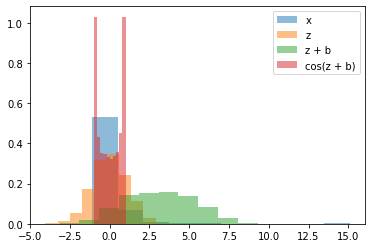

In [18]:
# quick distribution analysis
z = x @ B.T
plt.hist(x[0], label="x", density=True, alpha=0.5)
plt.hist(z[0], label="z", density=True, alpha=0.5)
plt.hist(z[0] + b, label="z + b", density=True, alpha=0.5)
plt.hist(h[0], label="cos(z + b)", density=True, alpha=0.5)
plt.legend()
plt.show()

In [19]:
# validate accuracy
acc = validate_hdaccuracy(h, y)
print(f"HD accuracy in this dataset: {100*acc:.6f}%")

HD accuracy in this dataset: 68.000000%


In [20]:
# few asserts
def mse(a, b):
  return np.mean((a - b)**2)
z_rec = decode_linear(z[0], B)
print(f"z_rec error: {mse(x[0], z_rec):.6f}")  # linear decode is good
print(f"h error: {mse(h, np.cos(z + b)):.6f}")  # rbf encoding is good

ind = individual(DIMENSION, B, b, h[0])
c_k = ind.chrom_k.copy()
c_s = ind.chrom_s.copy()
z_ind = ind.z.copy()
fit_ind = ind.fit + 0
ind2 = individual(DIMENSION, B, b, h[0])
ind.mutate()
ind.crossover(ind2)
newc_k = ind.chrom_k.copy()
newc_s = ind.chrom_s.copy()
newz_ind = ind.z.copy()
newfit_ind = ind.fit + 0
print(f"chrom error: {mse(c_k, newc_k) + mse(c_s, newc_s):.6f}")  # no inplace operators
print(f"z ind error: {mse(z_ind, newz_ind):.6f}")  # no inplace z :/
print(f"fit ind error: {mse(fit_ind, newfit_ind):.6f}")  # no inplace fit :/

z_rec error: 0.000000
h error: 0.000000
chrom error: 0.000000
z ind error: 0.000000
fit ind error: 0.000000
